<a href="https://colab.research.google.com/github/pcfabre/VehicleDetection/blob/main/Performance_without_annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!git clone https://github.com/pcfabre/VehicleDetection.git 'content'

fatal: destination path 'content' already exists and is not an empty directory.


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-6t05xc85
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-6t05xc85
  Resolved https://github.com/facebookresearch/detectron2.git to commit 337ca3490fa7879ceeeadf6c2b73d67504ff4b4f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=5739632 sha256=a1f8fc3fb2f1ae79cf800fee7c975

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
# import some common libraries
import json
import os
import cv2
import random
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Setup detectron2 logger
import torch
import torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [47]:
# select and display one random image from the training set
TRAIN_DIR = '/content/VehicleDetection/train'
TEST_DIR = '/content/VehicleDetection/test'
img_file = f"{TRAIN_DIR}/images/aguanambi-3135_png_jpg.rf.070647d8f9026036377565d3a0ec7fe8.jpg"

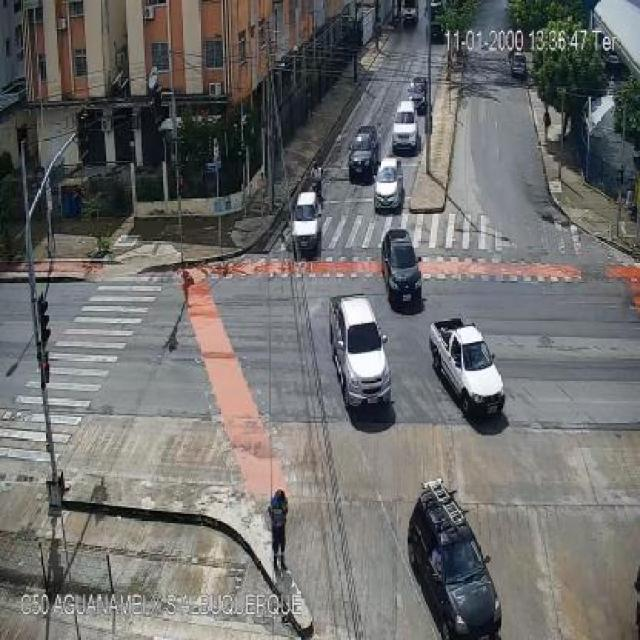

In [48]:
im = cv2.imread(img_file)
if IN_COLAB:
    cv2_imshow(im)
else:
    plt.imshow(im)

In [54]:
# is there a gpu
cfg = get_cfg()
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

no gpu


In [89]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.45

In [90]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[11/03 21:18:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


In [91]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 2, 2, 2, 7, 2, 2, 2, 6, 2, 0])
Boxes(tensor([[266.9457, 486.3504, 289.8614, 575.8382],
        [329.1772, 294.5648, 394.2594, 421.9491],
        [372.8513, 161.2308, 404.0047, 212.4927],
        [381.2591, 228.2690, 423.6107, 308.4764],
        [424.3687, 313.8979, 506.8096, 429.7718],
        [356.2390, 124.1461, 379.4516, 149.8136],
        [392.3903, 102.2048, 420.9112, 155.2120],
        [347.6062, 127.9445, 377.8015, 185.0607],
        [291.8171, 179.5597, 321.5081, 258.6451],
        [428.5526, 316.4946, 507.0693, 425.6854],
        [543.2707, 110.3370, 551.1824, 136.8779]]))


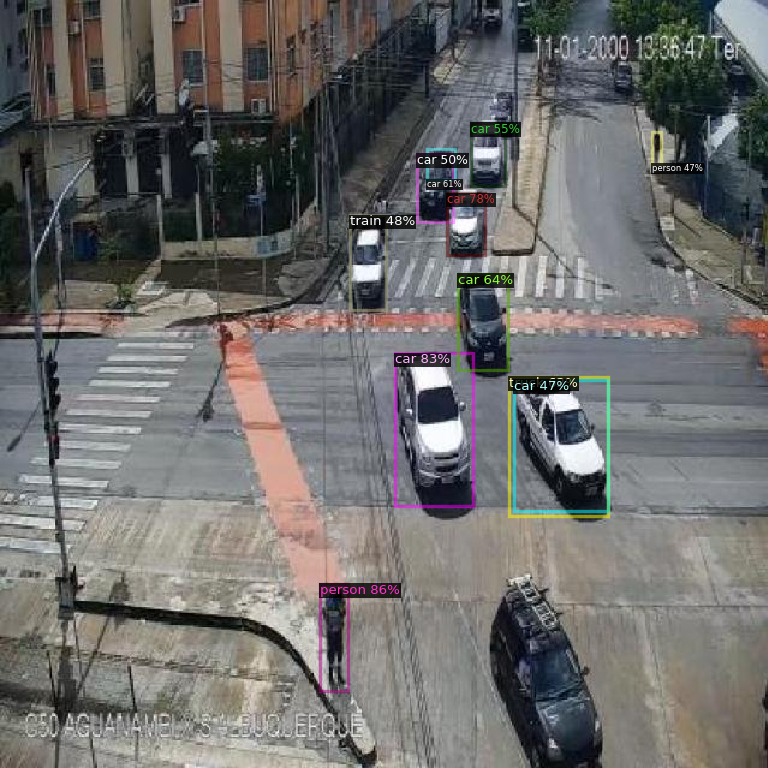

In [92]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
if IN_COLAB:
    cv2_imshow(out.get_image()[:, :, ::-1])
else:
    plt.imshow(out.get_image()[:, :, ::-1])

In [92]:
!git add